<a href="https://colab.research.google.com/github/tombresee/PyTorch/blob/main/ENTER/notebooks/Pytorch_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation for Computer Vision with PyTorch (Part 1: Image Classification)

Let's install PyTorch, and update PIL.

In [8]:
!pip3 install torch
!pip3 install torchvision
!pip3 install pillow

# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
# import os
# os._exit(00)

Next, import all libraries and configure matplotlib to display larger plots.

In [9]:
import PIL
import numpy as np
import torch
import torchvision

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

We need some sample images to perform augmentation. Let's import them from the pytorch-examples repository.

In [11]:
!git clone https://github.com/fabioperez/pytorch-examples/

fatal: destination path 'pytorch-examples' already exists and is not an empty directory.


Augmenting data with PyTorch is very straightforward. We can use the transforms provided in torchvision: [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html).

To compose several transforms together, we use [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) and pass the transforms as a list. The transforms are applied following the list order.

**Important note**

For training we should probably also add [`transforms.ToTensor`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) to convert the images to a PyTorch Tensor and [`transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) to normalize the images according to the network that you will train. I'm omitting these steps since my focus for this tutorial is to display the augmented images.


In [12]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

We then pass the transforms to [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) and the images will be automatically augmented.

If you want to define your own [dataset](https://pytorch.org/docs/master/torchvision/datasets.html) class, you just have to call `transforms(samples)` to perform the transforms on your samples. Check the source code for [`ImageFolder`](https://github.com/pytorch/vision/blob/4db0398a2b02aae790013efbc868f2d795eb2ef7/torchvision/datasets/folder.py#L150) for more details.

In [13]:
dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

That's all! Let's visualize some of the transformed images:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


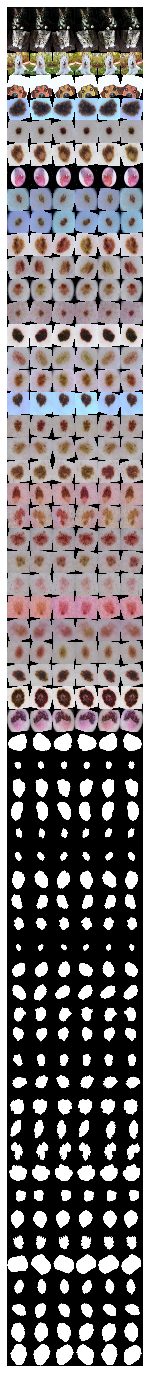

In [14]:
show_dataset(dataset)

Ok, but the augmentations available on PyTorch are very simple. What if we want to perform more interesting augmentations?

Let's use [imgaug](https://github.com/aleju/imgaug) to achieve that.

In [15]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

  Cloning https://github.com/aleju/imgaug to /tmp/pip-req-build-vyfcfvbl
  Running command git clone -q https://github.com/aleju/imgaug /tmp/pip-req-build-vyfcfvbl
  Created wheel for imgaug: filename=imgaug-0.4.0-cp36-none-any.whl size=971107 sha256=db077ab39c5421967b37227f0f1e6bb099e498f7a4a6bf943b2ce25b1923a042
  Stored in directory: /tmp/pip-ephem-wheel-cache-3sw33iil/wheels/9c/f6/aa/41dcf2f29cc1de1da4ad840ef5393514bead64ac9e644260ff
Successfully built imgaug
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


We can perform more complex augmentation and define more complex behaviors with imgaug.

Besides having more image transformation techniques, imgaug also has interesting behaviors such as [`Sometimes`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sometimes), [`SomeOf`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#someof) and [`OneOf`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#oneof).

Note that for imgaug, we should convert the PIL images to NumPy arrays before applying the transforms.

You should always be careful with the `dtype` and dimension ordering when applying data augmentation and training neural networks. It's a good practice to visualize the augmented images and print some of the input values before training a neural network.

In [16]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


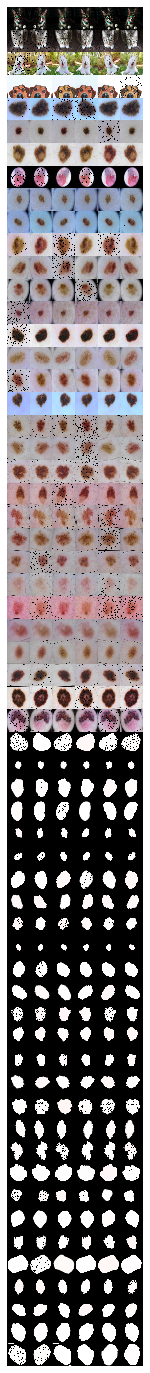

In [17]:
show_dataset(dataset)

imgaug also accepts a list of images instead of a single image. To augment them, use `aug.augment_images`. This may be useful if you are implementing a custom dataset that will load several images at once, before augmenting them. 

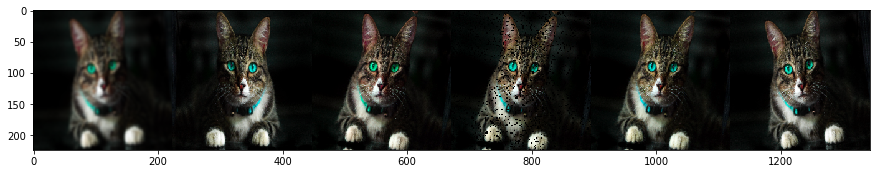

In [18]:
aug = iaa.Affine(rotate=(-40, 40), mode='symmetric')
imgs = [np.asarray(dataset[0][0]) for _ in range(6)]
aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))

If you want to create your own image transformations, you just have to write a Python function that will transform the given image (or images) and use it with [`transforms.Lambda`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Lambda), [`iaa.Lambda`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#lambda), or to call it directly in a custom transform class.

Mixing PyTorch and imgaug transforms is also very simple:

/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


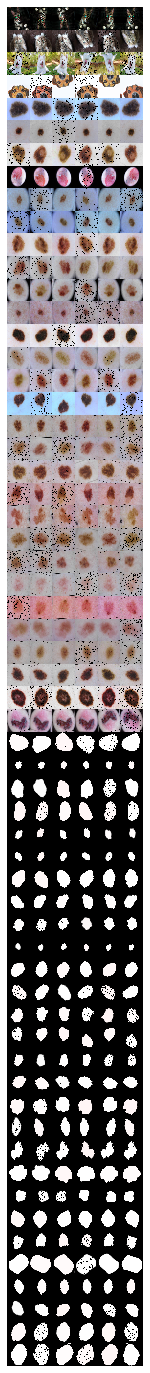

In [19]:
transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip()
])

dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

show_dataset(dataset)

# Time

Let's perform a simple benchmark to compare the running time for imgaug and for PyTorch. We can see that the results are very similar for the same augmentation techniques.

In [20]:
import time

transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20)
])

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.AddToHueAndSaturation(value=(-20, 20), per_channel=True),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='constant'),
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms_imgaug = ImgAugTransform()

datasets = {
'pytorch': torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms_pytorch),
'imgaug' : torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms_imgaug)
}

times = {'pytorch': [], 'imgaug': []}
for _ in range(20):
  for mode in ('pytorch', 'imgaug'):
    start = time.time()
    img_pytorch = np.vstack((np.hstack((np.asarray(datasets[mode][i][0]) for _ in range(6))) for i in range(4)))
    end = time.time()
    times[mode].append(end - start)
    
for mode in ('pytorch', 'imgaug'):
  t = np.array(times[mode])
  print("{}: {:.04f}".format(mode, t.min()))

/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:188: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


pytorch: 5.9117
imgaug: 5.9392
